# 数据预处理

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from ase.io import read
from pprint import pprint
import matplotlib.pyplot as plt
from collections import Counter
from dscribe.descriptors import SOAP
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold

with open('./data/supecon.csv', 'r') as file:
    data = pd.read_csv(file)
    pattern = r'([A-Z][a-z]?)(\d*)'
    elements = data['Formula'].str.findall(pattern).apply(lambda x: [match[0] for match in x])
    all_elements = set()
    all_elements.update(elements.explode().unique())
    all_elements = list(all_elements)
    cifs = data['cif']
    la = data['la']
    wlog = data['wlog']
    Tc_AD = data['Tc_AD']
    features = []
    labels = []
    # 创建标准化器对象
    scaler = StandardScaler()
    # 创建SOAP描述符对象
    soap = SOAP(
        species=all_elements,
        r_cut=5,# r_cut: 这是SOAP的截止距离，决定了参与计算的原子邻域的范围。选择合适的r_cut值可以影响计算的精度和效率。一般情况下，r_cut应根据原子之间的距离和体系的性质来选择，通常设置为5到10埃（Å）。
        n_max=3,# n_max: 表示考虑的原子数的最大数量。通常在体系较为复杂，原子数较多的情况下，n_max可以设置得较高。一般选择2到4就足够，因为过高的值可能增加计算成本而收益有限。
        l_max=5,# l_max: 这是球面谐函数的最大角量子数，它决定了描述电子环境的复杂程度。通常l_max值设置在3到6之间，具体取决于所需的描述精度。
        sigma=0.2,# sigma: 这是平滑化参数，影响SOAP描述符的平滑程度。较小的sigma可能会导致计算结果对局部结构变化敏感，而较大的sigma则可能使得描述符过于平滑而丢失细节。一般建议从0.1开始选择，根据结果进行调整。
        compression={"mode":"off","species_weighting":None},
        sparse=False,
        dtype='float32'
    )

features = []
labels = []
max_data = min(400,len(cifs))
for i in tqdm(range((max_data)),desc=f"读取并用ase解析cif文件中{max_data}条数据,生成SOAP描述符"):
    cif_file = data.loc[i,"cif"]
    with open('temp_file.cif','w') as cif_output:
        cif_output.write(cif_file)
    atoms = read('temp_file.cif')
    soap_descriptors = scaler.fit_transform(np.array(soap.create(atoms),dtype=np.float32))  # 转换为numpy数组ndarray
    # 如果 soap.create(atoms) 返回的是一个稀疏数组
    # sparse_descriptors = soap.create(atoms)
    # dense_descriptors = sparse_descriptors.todense()  # 手动转换为密集数组
    # soap_descriptors = scaler.fit_transform(np.array(dense_descriptors, dtype=np.float64))

    features.append(soap_descriptors)
    # features.append(soap_descriptors.flatten())
    labels.append(data.loc[i,"Tc_AD"])
    # features是一个包含多个ndarray的列表
print(len(features))
# 计算最大长度和宽度
max_length = max(feature.shape[0] for feature in features)
max_width = max(feature.shape[1] for feature in features)

# 使用resize调整特征大小
# a.resize(new_shape)用0填充和numpy.resize(a,new_shape)用a中数据重复填充
padded_features = np.array([
    np.resize(feature, (max_length, max_width))
    for feature in features
], dtype=features[0].dtype)

pprint(f'Padded features shape: {padded_features.shape}')

# 划分数据集，random_state=42为随机种子，设置为固定值可以保证每次运行结果相同
X_train, X_test, y_train, y_test = train_test_split(padded_features, labels, test_size=0.2, random_state=42, shuffle=True)

# 将列表转换为 numpy 数组
X_train = np.reshape(np.array(X_train),(int(max_data*0.8),-1))
X_test = np.reshape(np.array(X_test),(int(max_data*0.2),-1))
y_train = np.array(y_train)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

读取并用ase解析cif文件中400条数据,生成SOAP描述符: 100%|██████████| 400/400 [00:05<00:00, 71.10it/s]


400
'Padded features shape: (400, 8, 114660)'
X_train shape: (320, 917280)
X_test shape: (80, 917280)
y_train shape: (320,)
y_test shape: (80,)


## 随机森林

训练模型，生成100棵树中......: 100%|██████████| 100/100 [14:08<00:00,  8.49s/it]


Training MSE: [np.float64(0.0013896942109687298)]
Test MSE: [np.float64(0.0014705441169852742)]


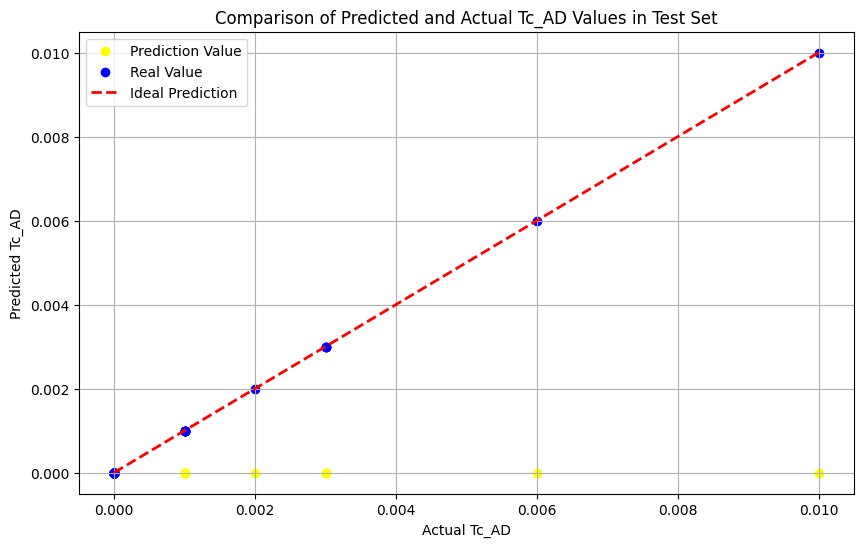

In [2]:
class DecisionTreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, max_depth=None):
        self.feature_index = feature_index  # 特征索引
        self.threshold = threshold            # 阈值
        self.left = left                      # 左子树
        self.right = right                    # 右子树
        self.value = value                    # 叶子节点的值
        self.max_depth = max_depth            # 最大深度

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        # 训练决策树，构建树的根节点
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # depth表示当前节点的深度，初始化为0
        # 如果没有样本
        if len(y) == 0:       
            return None
        
        # 停止条件
        if len(set(y)) == 1 or len(y) < self.min_samples_split or (self.max_depth is not None and depth >= self.max_depth):
            return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])
        
        # 特征和样本数量
        m, n = X.shape

        # 随机选择特征，feature_indices表示随机选择的特征索引
        feature_indices = np.random.choice(n, size=int(np.sqrt(n)), replace=True)# replace 重复选择

        best_feature, best_threshold = self._find_best_split(X, y, feature_indices)

        if best_feature is None:
            return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])

        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold

        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return DecisionTreeNode(feature_index=best_feature, threshold=best_threshold,
                                left=left_child, right=right_child)

    def _find_best_split(self, X, y, feature_indices):
        # 找到最佳分割点,即最佳特征和阈值
        best_feature, best_threshold = None, None
        best_impurity = float('inf')    # 保存当前最小的杂质值

        for feature in feature_indices:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                impurity = self._calculate_impurity(y[left_indices], y[right_indices])
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_impurity(self, left_y, right_y):
        # 计算当前分裂的杂质，均方误差
        total_samples = len(left_y) + len(right_y)
        if total_samples == 0:
            return 0
        
        left_mean = np.mean(left_y) if len(left_y) > 0 else 0
        right_mean = np.mean(right_y) if len(right_y) > 0 else 0

        left_mse = np.mean((left_y - left_mean) ** 2) if len(left_y) > 0 else 0
        right_mse = np.mean((right_y - right_mean) ** 2) if len(right_y) > 0 else 0

        # 计算加权均方误差
        impurity = (len(left_y) / total_samples) * left_mse + (len(right_y) / total_samples) * right_mse
        return impurity

    def predict(self, X):
        # 预测样本的标签
        return np.array([self._predict_sample(sample) for sample in X])

    def _predict_sample(self, sample):
        # 递归预测样本的标签
        node = self.root
        while node.value is None:
            if sample[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

class RandomForest:

    def __init__(self, n_trees=100, max_depth=10, min_samples_split=2):
        self.n_trees = n_trees
        self.max_depth = max_depth      # 小：5-10;中:10-30;大:30以上
        self.min_samples_split = min_samples_split  # 表示每个结点分裂所需的最小样本数
        self.trees = []

    def fit(self, X, y):
        for _ in tqdm(range(self.n_trees),desc=f"训练模型，生成{self.n_trees}棵树中......"):
            self.trees.append(self._fit_tree(X, y))

    def _fit_tree(self, X, y):
        # 有放回抽样
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_sample = X[indices]
        y_sample = y[indices]
        tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        tree.fit(X_sample, y_sample)
        return tree

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        # 使用np.apply_along_axis可以进一步优化
        return [Counter(tree_prediction).most_common(1)[0][0] for tree_prediction in tree_predictions.T]

if __name__ == '__main__':
    k = 5
    kf = KFold(n_splits=k, shuffle=True)
    predictions = []
    mse_train_list = []
    mse_test_list = []

    # 进行k折交叉验证
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        forest = RandomForest(n_trees=100, max_depth=10, min_samples_split=2)
        forest.fit(X_train_fold, y_train_fold)
        
        y_k_pred = forest.predict(X_val_fold)
        predictions.append(y_k_pred)

    # 合并所有折的预测结果
    predictions = np.concatenate(predictions)

    # 输出训练集的MSE
    y_pred_train = forest.predict(X_train)
    mse_train = root_mean_squared_error(y_train, y_pred_train)
    mse_train_list.append(mse_train)
    print("Training MSE:", mse_train_list)

    # 输出测试集的MSE
    y_pred_test = forest.predict(X_test)
    mse_test = root_mean_squared_error(y_test, y_pred_test)
    mse_test_list.append(mse_test)
    print("Test MSE:", mse_test_list)

    # 绘制拟合曲线
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, color='yellow', label='Prediction Value')  # 预测值散点图
    plt.scatter(y_test, y_test, color='blue', label='Real Value')  # 实际值散点图
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Ideal Prediction')
    plt.xlabel('Actual Tc_AD')
    plt.ylabel('Predicted Tc_AD')
    plt.title('Comparison of Predicted and Actual Tc_AD Values in Test Set')
    plt.legend()
    plt.grid()
    plt.show()